In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from stockstats import StockDataFrame

# libraries for plotting
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic", rc={'figure.figsize':(11,8)}) 
pd.options.display.float_format = '{:6.2f}'.format

In [2]:
def convert_df_to_stock_df(df):    
    sdf = df.copy()
    sdf.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'amount',
        'Volume': 'volume',
    }, inplace=True)
    sdf.index.names = ['date']
    return StockDataFrame(sdf)

# Valid start and end: YYYY-MM-DD
# Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
data = yf.download(
        tickers = "VOO",
        period = "10y",
        interval = "1d",
        group_by = 'ticker',
)

sdf = convert_df_to_stock_df(data)
sdf.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,amount,volume
date,,,,,,
2012-05-14,122.86,123.54,122.54,122.70,101.72,953250
2012-05-15,122.58,123.32,121.82,122.02,101.15,1532500
2012-05-16,122.52,123.02,121.50,121.50,100.72,331350
2012-05-17,121.58,121.68,119.66,119.66,99.20,288750
2012-05-18,120.16,120.40,118.56,118.72,98.42,760350


In [3]:
sdf['rsi']

# 売られすぎ、買われすぎのデータを追加
overbought_rsi = 70
oversold_rsi = 30

sdf['is_overbought'] = False
sdf['is_oversold'] = False
for index, row in sdf.iterrows():
    sdf.loc[index, 'is_overbought'] = sdf.loc[index]['rsi'] >= overbought_rsi
    sdf.loc[index, 'is_oversold'] = sdf.loc[index]['rsi'] <= oversold_rsi
sdf.head()

# rsiが計算できないデータを除外
for index, row in sdf.iterrows():
    if row['rsi'] == 0 or np.isnan(row['rsi']):
        print("Delete → ", index)
        sdf = sdf.drop(index)

# plot rsi
# plot_data = sdf.copy()
# plot_data['rsi']

# plt.ticklabel_format(style='plain', axis = 'y') 
# sns.lineplot(data = plot_data, x= 'date', y = 'rsi').set_title('RSI')
# plt.legend(labels=["RSI"])
# plt.figure()

# 売られすぎた日
print("Total oversold day : " ,(sdf['is_oversold'] == True).sum())

# 買われすぎた日
print("Total overbought day : " ,(sdf['is_overbought'] == True).sum())


# ------------------------

data = sdf.copy()

p = 0 # USD
add = 10 # USD

data['principal'] = p

# RSIの購入パターン
data['rsi_current_value'] = p # 現在の試算評価額（ドル建）
data['rsi_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['rsi_capacity_to_buy'] = 0 # 買い付け余力金

# DCAの購入パターン
data['dca_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['dca_capacity_to_buy'] = 0 # 買い付け余力金

previous_index = sdf.index[0]

for index, row in data.iterrows():
    data.loc[index, 'principal'] = data.loc[previous_index, 'principal'] + add;

    # RSI
    data.loc[index, 'rsi_capacity_to_buy'] = data.loc[previous_index, 'rsi_capacity_to_buy'] + add;
    if data.loc[index,'is_oversold'] and data.loc[index, 'rsi_capacity_to_buy'] >= data.loc[index, 'amount']:
        data.loc[index, 'rsi_shares'] = (data.loc[index, 'rsi_capacity_to_buy'] // data.loc[index, 'amount']) + data.loc[previous_index, 'rsi_shares']
        data.loc[index, 'rsi_capacity_to_buy'] = data.loc[index, 'rsi_capacity_to_buy'] % data.loc[index, 'amount']
    else:
        data.loc[index, 'rsi_shares'] = data.loc[previous_index, 'rsi_shares']
    data.loc[index, 'rsi_current_value'] = (data.loc[index, 'amount'] * data.loc[index, 'rsi_shares']) + data.loc[index, 'rsi_capacity_to_buy']
    
    # DCA 
    data.loc[index, 'dca_capacity_to_buy'] = data.loc[previous_index, 'dca_capacity_to_buy'] + add;
    if data.loc[index, 'dca_capacity_to_buy'] >= data.loc[index, 'amount']:
        data.loc[index, 'dca_shares'] = (data.loc[index, 'dca_capacity_to_buy'] // data.loc[index, 'amount']) + data.loc[previous_index, 'dca_shares']
        data.loc[index, 'dca_capacity_to_buy'] = data.loc[index, 'dca_capacity_to_buy'] % data.loc[index, 'amount']
    else:
        data.loc[index, 'dca_shares'] = data.loc[previous_index, 'dca_shares']
    data.loc[index, 'dca_current_value'] = (data.loc[index, 'amount'] * data.loc[index, 'dca_shares']) + data.loc[index, 'dca_capacity_to_buy']
    
    # 前日
    previous_index = index
    
result_data = data
result_data

Delete →  2012-05-14 00:00:00
Delete →  2012-05-15 00:00:00
Delete →  2012-05-16 00:00:00
Delete →  2012-05-17 00:00:00
Delete →  2012-05-18 00:00:00
Total oversold day :  41
Total overbought day :  181


,open,high,low,close,amount,volume,rs_14,rsi,is_overbought,is_oversold,principal,rsi_current_value,rsi_shares,rsi_capacity_to_buy,dca_shares,dca_capacity_to_buy,dca_current_value
date,,,,,,,,,,,,,,,,,
2012-05-21,119.04,120.78,118.90,120.72,100.07,271550,0.59,37.17,False,False,10,10.00,0.00,10.00,0.00,10.00,10.00
2012-05-22,121.08,121.88,120.18,120.98,100.29,654450,0.67,40.27,False,False,20,20.00,0.00,20.00,0.00,20.00,20.00
2012-05-23,120.10,121.14,118.92,120.98,100.29,176000,0.67,40.27,False,False,30,30.00,0.00,30.00,0.00,30.00,30.00
2012-05-24,121.38,121.50,120.24,121.20,100.47,112050,0.76,43.04,False,False,40,40.00,0.00,40.00,0.00,40.00,40.00
2012-05-25,121.22,121.50,120.62,120.92,100.24,336400,0.68,40.47,False,False,50,50.00,0.00,50.00,0.00,50.00,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06,378.01,381.28,372.95,378.10,378.10,7958700,0.64,38.88,False,False,25080,46830.26,122.00,702.06,130.00,72.50,49225.50
2022-05-09,372.36,373.56,364.50,365.90,365.90,10793200,0.50,33.51,False,False,25090,45351.86,122.00,712.06,130.00,82.50,47649.50
2022-05-10,371.90,373.22,362.91,366.84,366.84,7870800,0.52,34.26,False,False,25100,45476.54,122.00,722.06,130.00,92.50,47781.70


<Figure size 792x576 with 0 Axes>

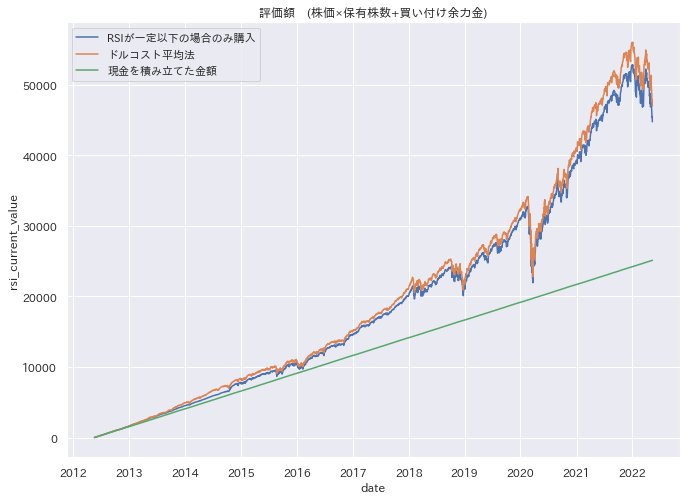

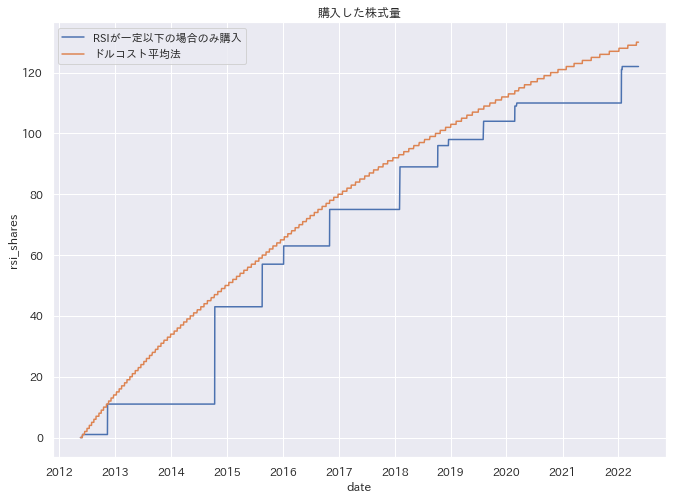

<Figure size 792x576 with 0 Axes>

In [4]:
plot_data = result_data.copy()

# now for the actual plot
sns.lineplot(data = plot_data, x= 'date', y = 'rsi_current_value')
sns.lineplot(data = plot_data, x= 'date', y = 'dca_current_value')
sns.lineplot(data = plot_data, x= 'date', y = 'principal').set_title('評価額　(株価×保有株数+買い付け余力金)')
plt.legend(labels=["RSIが一定以下の場合のみ購入","ドルコスト平均法", "現金を積み立てた金額"])
plt.figure()

sns.lineplot(data = plot_data, x= 'date', y = 'rsi_shares')
sns.lineplot(data = plot_data, x= 'date', y = 'dca_shares').set_title('購入した株式量')
plt.legend(labels=["RSIが一定以下の場合のみ購入","ドルコスト平均法"])
plt.figure()